In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import cv2
from torchvision.utils import flow_to_image
from torchvision.io import decode_image
from torchvision.io import read_video
from torchvision.io import write_png
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
plt.rcParams["savefig.bbox"] = "tight"
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyav

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 33.0 MB/s eta 0:00:00


In [ ]:
!cp /content/drive/MyDrive/ISD_Lab/Exp-5/FlowNetS.py /content/FlowNetS.py
!cp /content/drive/MyDrive/ISD_Lab/Exp-5/util.py /content/util.py

In [ ]:
from FlowNetS import FlowNetS

model = FlowNetS()
model_dict = torch.load("flownets_bn_EPE2.459.pth", map_location = device )
model.load_state_dict(model_dict["state_dict"])
model = model.eval()
model = model.to(device)

/content/util.py:11: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  warnings.warn(
<ipython-input-8-8e0ec439188c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to 

In [ ]:
def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = TF.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [ ]:
tform = T.Compose([
        T.Normalize(0,255),
        T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

inv_tform = T.Compose([
    T.Normalize(mean = (-1,-1,-1), std = (2,2,2)),
])

In [ ]:
# Extract file pairsdataset.zip

!unzip /content/pairs_dataset.zip

Archive:  /content/pairs_dataset.zip
  inflating: Image_flows/frame_0001.png  
  inflating: Image_flows/frame_0002.png  
  inflating: Image_flows/frame_0003.png  
  inflating: Image_flows/frame_0004.png  
  inflating: Image_flows/frame_0005.png  
  inflating: Image_flows/frame_0006.png  
  inflating: Image_flows/frame_0007.png  
  inflating: Image_flows/frame_0008.png  
  inflating: Image_flows/frame_0009.png  
  inflating: Image_flows/frame_0010.png  
  inflating: Image_pairs/frame_0001.png  
  inflating: Image_pairs/frame_0002.png  
  inflating: Image_pairs/frame_0003.png  
  inflating: Image_pairs/frame_0004.png  
  inflating: Image_pairs/frame_0005.png  
  inflating: Image_pairs/frame_0006.png  
  inflating: Image_pairs/frame_0007.png  
  inflating: Image_pairs/frame_0008.png  
  inflating: Image_pairs/frame_0009.png  
  inflating: Image_pairs/frame_0010.png  
  inflating: Image_pairs/frame_0011.png  
  inflating: Image_pairs/frame_0012.png  
  inflating: Image_pairs/frame_0013.png

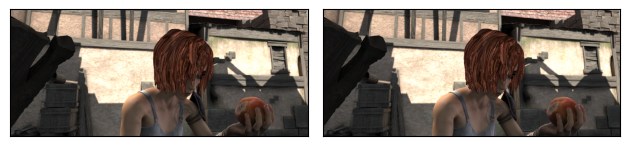

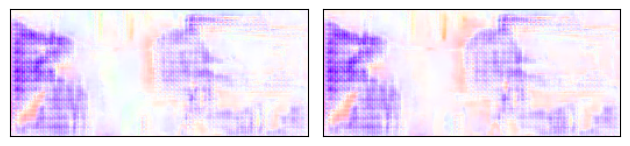

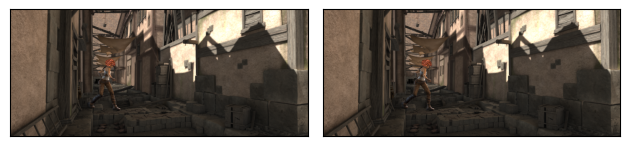

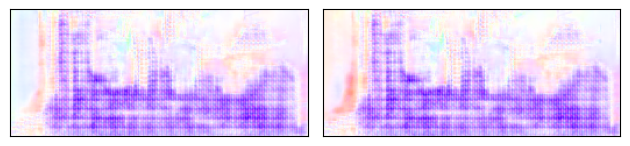

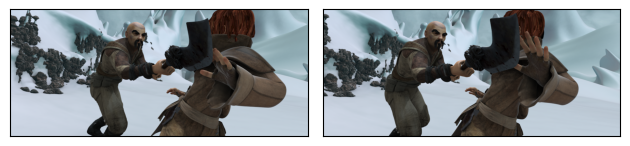

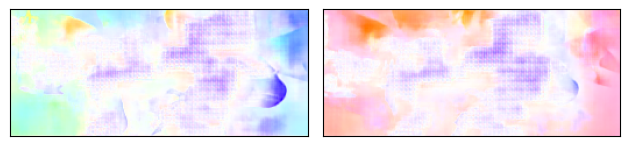

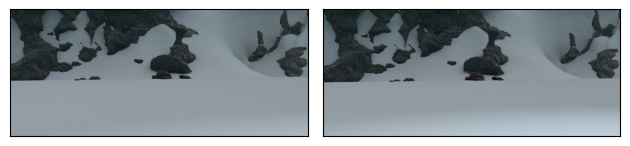

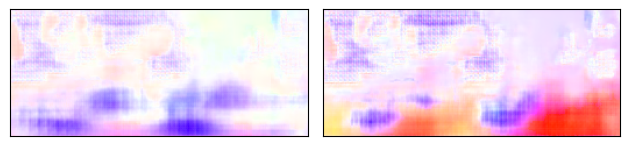

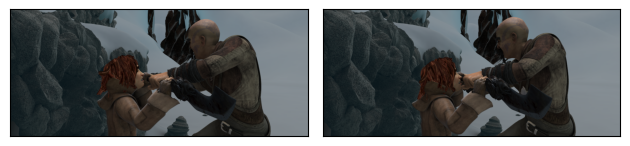

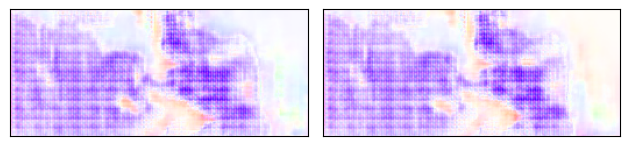

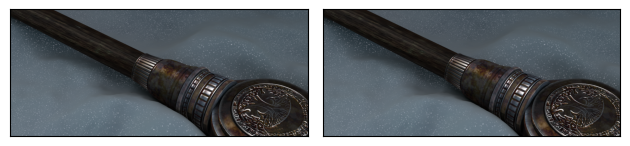

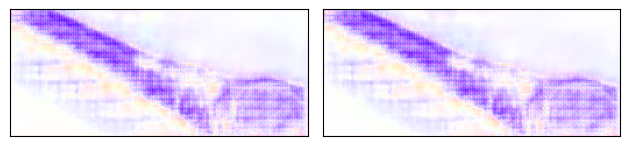

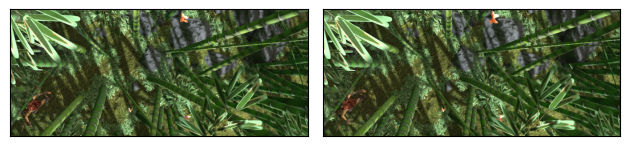

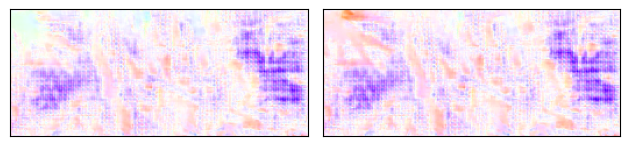

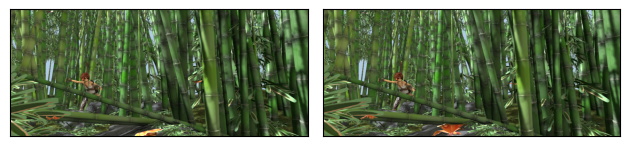

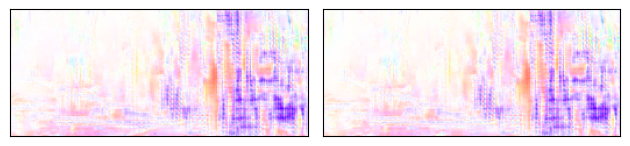

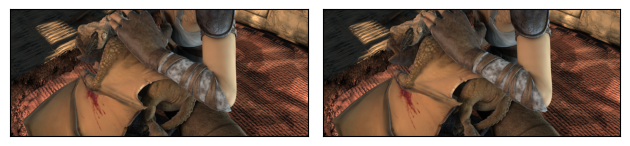

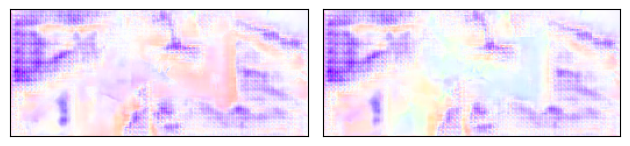

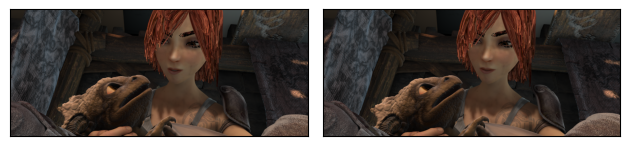

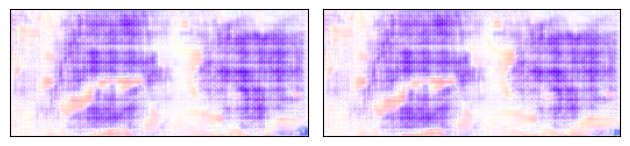

In [ ]:
# img_path = "/content/drive/MyDrive/ISD_Lab/Exp-5/sintel/"
img_path = '/content/Image_pairs/'

img_files = sorted(os.listdir(img_path))
for i in range(0,len(img_files),2):
    img1 = decode_image(img_path + img_files[i])
    img2 = decode_image(img_path + img_files[i+1])

    plot([img1, img2])

    img1 = img1.float()
    img2 = img2.float()

    img1 = tform(img1)
    img2 = tform(img2)

    ip1 = torch.cat((img1,img2))
    ip1 = ip1.unsqueeze(0)

    ip2 = torch.cat((img2,img1))
    ip2 = ip2.unsqueeze(0)

    op1 = model(ip1.to(device))
    op2 = model(ip2.to(device))

    flow_img1 = flow_to_image(op1).squeeze(0)
    flow_img2 = flow_to_image(op2).squeeze(0)

    plot([flow_img1, flow_img2])

In [ ]:
def pre_process(img):
    img = TF.resize(img, size=[520, 960], antialias=False)
    img = img.float()
    return tform(img)

In [ ]:
from torchvision.models.optical_flow import raft_large

raft_model = raft_large(pretrained=True, progress=False).to(device)
raft_model = raft_model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/raft_large_C_T_SKHT_V2-ff5fadd5.pth" to /root/.cache/torch/hub/checkpoints/raft_large_C_T_SKHT_V2-ff5fadd5.pth


In [ ]:
class CustomDataset(Dataset):
    def __init__(self,path,frame_nos,train = False,transform = None, max_offset = 5):
        if(train):
            self.path = path + "train/"
        else:
            self.path = path + "test/"

        self.frame_fldrs = os.listdir(self.path)
        self.frame_fldrs = sorted([f for f in self.frame_fldrs if os.path.isdir(os.path.join(self.path, f))],
                                  key=lambda x: int(x.split('_')[1]))
        self.max_offset = max_offset
        self.transform = transform
        self.frame_nos = frame_nos

    def __len__(self):
        return len(self.frame_fldrs)

    def __getitem__(self,idx):
        frame_no = self.frame_nos[idx]
        img1 = decode_image(self.path + self.frame_fldrs[idx] + "/" + f"Frame_{frame_no}.png")
        img2 = decode_image(self.path + self.frame_fldrs[idx] + "/" + f"Frame_{frame_no + self.max_offset}.png")

        flow = torch.load(f"{trainset.path}" + f"{trainset.frame_fldrs[idx]}" + "/flow_" + f"{trainset.frame_nos[idx]}_{trainset.frame_nos[idx] + trainset.max_offset}.pth").squeeze(0)
        # To match the flow shape of flownet
        flow = F.avg_pool2d(flow,(4,4))

        if(self.transform):
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (img1,img2),flow

## **Video data and processing**

In [ ]:
!unzip /content/videos.zip

Archive:  /content/videos.zip
  inflating: videos/VID_20250303_195949.mp4  
  inflating: videos/VID_20250303_200034.mp4  
  inflating: videos/VID_20250303_200051.mp4  
  inflating: videos/VID_20250303_200116.mp4  
  inflating: videos/VID_20250303_200141.mp4  
  inflating: videos/VID_20250303_200216.mp4  
  inflating: videos/VID_20250303_200243.mp4  
  inflating: videos/VID_20250303_200256.mp4  
  inflating: videos/VID_20250303_200309.mp4  
  inflating: videos/VID_20250303_200319.mp4  


In [ ]:
import os
import cv2
import torch
from torchvision.transforms.functional import resize
from torchvision.transforms import ToTensor

def process_videos(video_folder, N, H, W):

    all_frames = []
    # Iterate through the videos in the folder
    video_files = [f for f in os.listdir(video_folder) if f.endswith('.mp4')][:10]  # Limit to 10 videos
    for video_file in video_files:
        video_path = os.path.join(video_folder, video_file)

        # Open the video file
        cap = cv2.VideoCapture(video_path)
        frame_count = 0

        while frame_count < N:
            ret, frame = cap.read()
            if not ret:  # Break if there are no more frames
                break

            # Resize the frame to (H, W)
            frame_resized = cv2.resize(frame, (W, H))


            frame_tensor = ToTensor()(frame_resized)  # Converts to [C, H, W]

            all_frames.append(frame_tensor)
            frame_count += 1

        cap.release()

    # Stack all frames into a single tensor of shape [N * num_videos, C, H, W]
    video_tensor = torch.stack(all_frames[:N * len(video_files)])  # Ensure we only take N frames per video

    return video_tensor


# Fetching videos

video_folder = "./videos"
N = 10
H = 64
W = 64

output_tensor = process_videos(video_folder, N, H, W)
print(f"Output tensor shape: {output_tensor.shape}")  # Should be [N * num_videos, C, H, W]


Output tensor shape: torch.Size([100, 3, 64, 64])


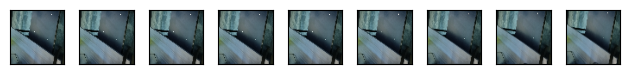

In [ ]:
plot(output_tensor[:9])

In [ ]:
import os
import shutil

# Define paths
frames_folder = './frames'
train_folder = os.path.join(frames_folder, 'train')
test_folder = os.path.join(frames_folder, 'test')

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Get all frame files
frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.png')])

# Calculate split indices
num_frames = len(frame_files)
train_count = int(num_frames * 0.8)  # 24:6 ratio (80% for training)

# Split frames into train and test
train_files = frame_files[:train_count]
test_files = frame_files[train_count:]

# Move files to respective folders
for file in train_files:
    shutil.move(os.path.join(frames_folder, file), os.path.join(train_folder, file))

for file in test_files:
    shutil.move(os.path.join(frames_folder, file), os.path.join(test_folder, file))

# Output the result
len_train = len(os.listdir(train_folder))
len_test = len(os.listdir(test_folder))
print(f"Number of frames in train folder: {len_train}")
print(f"Number of frames in test folder: {len_test}")


Number of frames in train folder: 80
Number of frames in test folder: 20


In [ ]:
# chkpt_path = "/content/drive/MyDrive/ISD_Lab/Exp-5/checkpoints/"
# frames_path = "/content/drive/MyDrive/ISD_Lab/Exp-5/VideoDst/frames/"
frames_path = "/content/frames/"



frame_nos = [45, 1, 4, 4, 40, 10, 20, 22, 37, 24, 7, 25, 25, 13, 2, 39, 40, 24, 25, 18, 38, 26, 14, 9]

batch_size = 4
trainset = CustomDataset(frames_path,frame_nos,train = True,transform = pre_process)
trainloader = DataLoader(trainset,batch_size = batch_size,shuffle = False)

In [ ]:
best_epe = 1e9
opt = torch.optim.SGD(model.parameters(),lr = 1e-2,momentum = 0.9)
start_epoch = 0
end_epoch = 60


# chkpt = torch.load(chkpt_path+"checkpoint.pth")
# opt.load_state_dict(chkpt['opt_state_dict'])
# model.load_state_dict(chkpt['model_state_dict'])
# start_epoch = chkpt['epoch'] + 1
# end_epoch = start_epoch + 10


In [ ]:
model.train()

for ep in range(start_epoch,end_epoch):
    print(f"Epoch = {ep}")
    running_epe = 0.0
    for (f1,f2),gt_flows in trainloader:
        opt.zero_grad()
        fs = torch.cat((f1,f2),dim = 1)
        flows = model(fs.to(device))[0]
        epe = torch.norm(gt_flows.to(device) - flows, p = 2 ,dim = 1).mean()
        # print(epe)
        epe.backward()
        opt.step()
        running_epe = running_epe + epe.item()

    running_epe = running_epe / 6
    if(running_epe < best_epe):
        best_epe = running_epe

        torch.save({
            'epoch': ep,
            'model_state_dict': model.state_dict(),
            'opt_state_dict': opt.state_dict(),
            'best_epe': best_epe
        }, chkpt_path + "best_model.pth")

    torch.save({
            'epoch': ep,
            'model_state_dict': model.state_dict(),
            'opt_state_dict': opt.state_dict(),
            'best_epe': best_epe
        }, chkpt_path + "checkpoint.pth")

    print(f" epoch={ep} | Loss {running_epe} \n")

Epoch = 0


<ipython-input-10-c26d14aad459>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow = torch.load(f"{trainset.path}" + f"{trainset.frame_fldrs[idx]}" + "/flow_" + f"{train

Loss at epoch=0:18.998939116795857
Epoch = 1
Loss at epoch=1:18.679492831230164
Epoch = 2
Loss at epoch=2:18.01492114861806
Epoch = 3
Loss at epoch=3:16.70039693514506
Epoch = 4
Loss at epoch=4:18.60664439201355
Epoch = 5
Loss at epoch=5:18.515123685201008
Epoch = 6
Loss at epoch=6:19.88225571314494
Epoch = 7
Loss at epoch=7:18.88739315668742
Epoch = 8
Loss at epoch=8:17.747438470522564
Epoch = 9
Loss at epoch=9:17.191499789555866
Epoch = 10
Loss at epoch=10:15.859925826390585
Epoch = 11
Loss at epoch=11:16.504045168558758
Epoch = 12
Loss at epoch=12:15.206836978594461
Epoch = 13
Loss at epoch=13:14.864570021629333
Epoch = 14
Loss at epoch=14:14.139276146888733
Epoch = 15
Loss at epoch=15:17.921831687291462
Epoch = 16
Loss at epoch=16:16.54554621378581
Epoch = 17
Loss at epoch=17:15.839054584503174
Epoch = 18
Loss at epoch=18:14.637943983078003
Epoch = 19
Loss at epoch=19:14.732916990915934
Epoch = 20
Loss at epoch=20:12.512808998425802
Epoch = 21
Loss at epoch=21:10.85769271850586
Epo

In [ ]:
best_epe

10.85769271850586

In [ ]:
# print(trainset.frame_nos)
# for idx,d in enumerate(trainset):
#     flow = raft_model(d[0][0].unsqueeze(0),d[0][1].unsqueeze(0))[-1]
#     plot([inv_tform(d[0][0]),inv_tform(d[0][1])])
#     plot(flow_to_image(flow))
#     torch.save(flow,f"{trainset.path}" + f"{trainset.frame_fldrs[idx]}" + "/flow_" + f"{trainset.frame_nos[idx]}_{trainset.frame_nos[idx] + trainset.max_offset}.pth")
#     pass

In [ ]:
# torch.cat((torch.randn(4,3,256,256),torch.randn(4,3,256,256)),dim = 1).shape

torch.Size([4, 6, 256, 256])